# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/MIT IDSS/ratings_Electronics.csv")

**Installing surprise library**

In [5]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [7]:
# Load the dataset with column names
df_original = pd.read_csv("/content/drive/MyDrive/MIT IDSS/ratings_Electronics.csv",
                          header=None, names=['user_id', 'prod_id', 'rating', 'timestamp'])

# Drop the 'timestamp' column
df = df_original.drop(columns=['timestamp'])

# Display the first few rows
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [8]:
# Display the last few rows.
df.tail()

,user_id,prod_id,rating
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [9]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [10]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [11]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [12]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [13]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [14]:
# Check the number of rows and columns and provide observations
# Display shape of the dataset
shape = df.shape
print(f"Dataset contains {shape[0]} rows and {shape[1]} columns.")


Dataset contains 125871 rows and 3 columns.


**Write your observations here:Dataset contains 125871 rows and 3 columns.**

### **Data types**

In [15]:
# Check Data types and provide observations
print(df.dtypes)

user_id     object
prod_id     object
rating     float64
dtype: object


**Write your observations here: user_id & prod_id are both object while rating is a float**

### **Checking for missing values**

In [16]:
# Check for missing values present and provide observations
print(df.isnull().sum())

user_id    0
prod_id    0
rating     0
dtype: int64


**Write your observations here: There is no missing values in the dataset. **

### **Summary Statistics**

In [17]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe().T

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Write your observations here:
Average Rating:

The mean rating is 4.29, which indicates that, on average, users tend to give highly positive ratings to products. This suggests that most users are satisfied with the products they purchase.

Rating Spread:

The standard deviation of 0.99 shows that the ratings are relatively spread out, but most ratings are clustered around the mean. This indicates some variability in user satisfaction, but the majority of ratings are still high.

Minimum and Maximum Ratings:

The minimum rating is 1.0, and the maximum is 5.0. This confirms that the dataset includes the full range of possible ratings, from very dissatisfied to very satisfied users.

Median Rating:

The median rating is 5.0, which is higher than the mean. This indicates that more than 50% of the ratings are 5 stars, further emphasizing the overall positive sentiment in the dataset.

Quartiles:

The 25th percentile (Q1) is 4.0, and the 75th percentile (Q3) is 5.0. This means:

25% of the ratings are 4 stars or below.

75% of the ratings are 5 stars.

This skewed distribution suggests that the majority of users are highly satisfied with the products, with only a small fraction giving lower ratings.

Implications for the Recommendation System:

The high average and median ratings suggest that users are generally satisfied with the products. However, the presence of lower ratings (1-3 stars) indicates that there are still opportunities to improve recommendations for users who are less satisfied.

The recommendation system should focus on identifying patterns in lower-rated products to avoid suggesting them to similar users, while also leveraging the high-rated products to enhance user satisfaction.**

### **Checking the rating distribution**

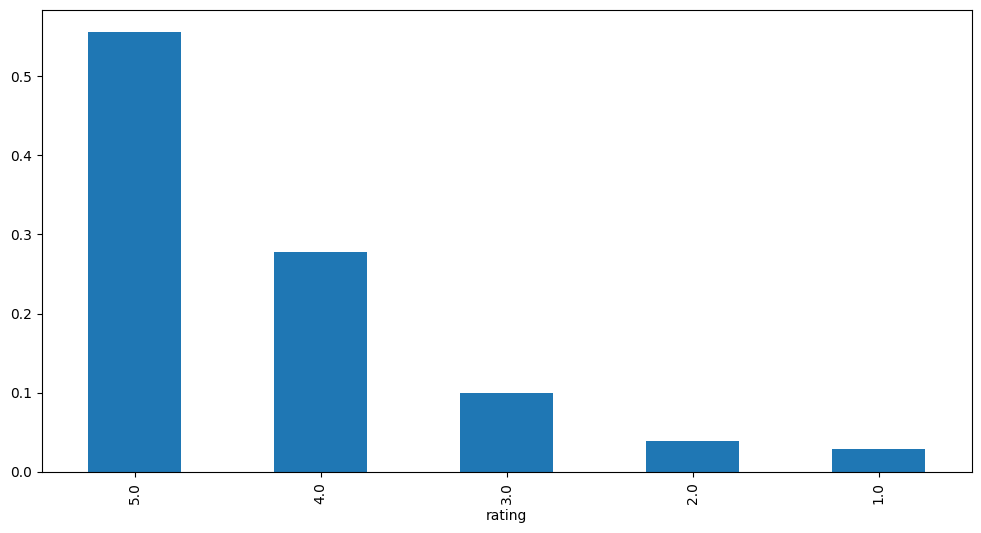

In [18]:
# Create the bar plot and provide observations
plt.figure(figsize = (12, 6))

df_final['rating'].value_counts(normalize=True).plot(kind = 'bar')

plt.show()

**Write your observations here:**
*The rating distribution is right-skewed, with most products receiving 5 stars. There's a sharp drop from 5 to 4 stars, and ratings decrease as we move down to lower scores. Ratings of 1 and 2 are rare, showing that most users are happy with the products and don’t often leave negative feedback. The trend suggests that people either love or dislike their purchases, with fewer giving moderate ratings like 3 or 4.
In short, the data reflects a generally positive sentiment, with more satisfied customers than dissatisfied ones. However, this could be influenced by a bias toward positive reviews, so it's something to keep in mind when interpreting the results.*

### **Checking the number of unique users and items in the dataset**

In [18]:
# Number of total rows in the data and number of unique user id and product id in the data
print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

The number of observations in the final data =  125871
Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  48190


**Write your observations here:**

Dataset Size: The final dataset used for analysis contains 125,871 observations, which represent individual ratings given by users to products.

User Base: There are 1,540 unique users in the raw dataset. This is the total number of distinct individuals who have provided ratings.
Product Catalog: The raw dataset includes 48,190 unique items. This represents the total number of different products available for rating.

Data Sparsity: Comparing the number of observations to the number of unique users and items, it's clear that the dataset is relatively sparse. There are many possible user-item combinations for which no rating is available. This is a common characteristic of recommendation system datasets.

### **Users with the most number of ratings**

In [19]:
# Top 10 users based on the number of ratings
top_10_users = df_final.groupby('user_id')['rating'].count().sort_values(ascending=False).head(10)
print(top_10_users)


user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: rating, dtype: int64


**Write your observations here:**
Top Users Dominate Ratings: The top 10 users have rated significantly more products than the average user.

Most Active User: User A5JLAU2ARJ0BO is the most active, with 520 ratings, making their preferences highly influential.

Impact on Recommendations: Since these top users contribute a large portion of ratings, their opinions shape the recommendation system.

Potential Bias: A few highly active users might skew recommendations, so it's important to balance their influence.

Useful Trends: These users' ratings highlight popular products, which can help recommend trending items to others.

Uneven Distribution: Most users rate only a few items, while a small group provides many ratings—this is a common trend in user-generated data.

Collaborative Filtering Works Well: Since active users rate diverse items, collaborative filtering can effectively use their preferences to suggest products to others.*


**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [19]:
# Calculate the average rating for each product
average_ratings = df.groupby('prod_id')['rating'].mean()


# Calculate the count of ratings for each product
rating_counts = df.groupby('prod_id')['rating'].count()


# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
    'AverageRating': average_ratings,
    'RatingCount': rating_counts
})

# Sort the dataframe by average of ratings in the descending order
final_rating_sorted = final_rating.sort_values(by='AverageRating', ascending=False)


# See the first five records of the "final_rating" dataset
print(final_rating_sorted.head())


            AverageRating  RatingCount
prod_id                               
0594451647            5.0            1
B003RRY9RS            5.0            1
B003RR95Q8            5.0            1
B003RIPMZU            5.0            1
B003RFRNYQ            5.0            2


Top-Rated Products:

The products with the highest average ratings are listed first. These are likely the most popular or highest-quality products.

Rating Count:

The RatingCount column shows how many ratings each product has received. Products with a high average rating and a high rating count are likely the most reliable and widely appreciated.

Usefulness for Recommendations:

This sorted list can be used to recommend top-rated products to users. However, it’s important to also consider the number of ratings (e.g., a product with a 5.0 average rating but only 1 rating may not be as reliable as a product with a 4.8 average rating and 200 ratings).

In [20]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def get_top_n_products(final_rating, min_interactions=50, n=10):
    # Finding products with minimum number of interactions
    filtered_products = final_rating[final_rating['RatingCount'] >= min_interactions]
    # Sorting values with respect to average rating
    sorted_products = filtered_products.sort_values(by='AverageRating', ascending=False)
    return sorted_products.head(n)

In [21]:
print("Top 10 Popular Products:")
print(get_top_n_products(final_rating_sorted, min_interactions=50, n=10))

Top 10 Popular Products:
            AverageRating  RatingCount
prod_id                               
B001TH7GUU       4.871795           78
B003ES5ZUU       4.864130          184
B0019EHU8G       4.855556           90
B006W8U2MU       4.824561           57
B000QUUFRW       4.809524           84
B000HPV3RW       4.803922           51
B001TH7GSW       4.803279           61
B000BQ7GW8       4.777778           54
B000N99BBC       4.772455          167
B002WE6D44       4.770000          100


**Observations:**


*   High Ratings Across the Board: All top 10 products have an average rating above 4.7, showing that users love them.
*   Product B001TH7GUU stands out with the highest average rating of 4.87 and 78 reviews, making it both popular and highly rated.

*   Different Levels of Popularity: Even though every top product has at least 50 ratings, some have way more, which could mean they are more trusted or better known.
*   Great Picks for Recommendations: These highly-rated products are strong candidates for recommendations since people seem to really enjoy them.

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [22]:
# Recommending top 5 products with 50 minimum interactions based on popularity
top_5_popular_products_50 = get_top_n_products(final_rating_sorted, min_interactions=50, n=5)
print(top_5_popular_products_50)

            AverageRating  RatingCount
prod_id                               
B001TH7GUU       4.871795           78
B003ES5ZUU       4.864130          184
B0019EHU8G       4.855556           90
B006W8U2MU       4.824561           57
B000QUUFRW       4.809524           84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [23]:
# Recommending top 5 products with 100 minimum interactions based on popularity
top_5_popular_products_100 = get_top_n_products(final_rating_sorted, min_interactions=100, n=5)
print(top_5_popular_products_100)

            AverageRating  RatingCount
prod_id                               
B003ES5ZUU       4.864130          184
B000N99BBC       4.772455          167
B002WE6D44       4.770000          100
B007WTAJTO       4.701220          164
B002V88HFE       4.698113          106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [24]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [25]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [26]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [27]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

In [28]:
from surprise import SVD
from surprise import accuracy

# Train an SVD model
algo = SVD()
algo.fit(trainset)

# Test the model
predictions = algo.test(testset)

# Evaluate the model
accuracy.rmse(predictions)

RMSE: 0.8907


0.8907126501600071

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options


# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1


# Fit the model on the training data


# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above


In [29]:
from surprise import KNNBasic
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from collections import defaultdict

# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}  # User-user similarity

# Initialize the KNNBasic model using sim_options provided, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Define the precision_recall_at_k function
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    # First map the predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@k: Proportion of recommended items that are relevant
        precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0)

        # Recall@k: Proportion of relevant items that are recommended
        recalls.append(n_rel_and_rec_k / n_rel if n_rel != 0 else 0)

    # Average precision and recall over all users
    precision = sum(precisions) / len(precisions)
    recall = sum(recalls) / len(recalls)

    # F1 score: Harmonic mean of precision and recall
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f1

# Generate predictions on the test set
test_predictions = sim_user_user.test(testset)

# Compute precision@k, recall@k, and F1 score
precision, recall, f1 = precision_recall_at_k(test_predictions, k=10, threshold=3.5)

# Print the results
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")
print(f"F1 Score@10: {f1:.4f}")

Precision@10: 0.8555
Recall@10: 0.8578
F1 Score@10: 0.8566


**Write your observations here:**

Accurate Recommendations: With a Precision@10 of 85.55%, most suggested items are relevant to users.

Covers User Interests Well: A Recall@10 of 85.78% shows the model captures a large portion of what users might like.

Balanced Performance: A high F1 Score (85.66%) confirms a strong balance between accuracy and coverage.

Overall Effectiveness: The model does a great job recommending items users will likely find interesting.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [30]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:The model predicted a rating of 3.4 for user "A3LDPF5FMB782Z" and item "1400501466", while the actual rating was 5.0. The prediction was possible and based on 5 neighbors. This indicates the prediction was not very accurate**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [31]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[df_final.prod_id != "1400501466"].user_id.unique()


array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [32]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
The model was unable to predict a personalized rating for user "A34BZM6S9L7QI4" and item "1400501466" due to insufficient neighboring users with similar preferences. The model couldn't find enough users with similar tastes to the target user who had also rated the target item. This made it difficult to personalize a prediction. So, it fell back to using the average rating of all items as a general estimate of 4.29.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [33]:
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader

# Load the dataset (assuming df_final is your DataFrame)
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [20, 30, 40],  # Number of neighbors
    'min_k': [1, 3, 5],  # Minimum number of neighbors
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],  # Similarity measures
        'user_based': [True]  # User-user similarity
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
best_rmse = gs.best_score['rmse']
print(f"Best RMSE Score: {best_rmse:.4f}")

# Combination of parameters that gave the best RMSE score
best_params = gs.best_params['rmse']
print("Best Parameters:", best_params)

Best RMSE Score: 0.9702
Best Parameters: {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [34]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {
    'name': 'cosine',  # Cosine similarity is commonly used for user-user CF
    'user_based': True  # Ensuring user-user collaborative filtering
}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=2, verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(predictions, k=10)

(0.8545397034527459, 0.8799903100035332, 0.8670782894707909)

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [35]:
from surprise import KNNBasic

# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=2, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Generate predictions
predictions = sim_user_user_optimized.test(testset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(predictions, k=10)

(0.8546670117322278, 0.8733737308981454, 0.863919117527206)

**Write your observations here:Tuning the model didn't lead to a big improvement. The model was already recommending relevant items well, but the tuned model might be slightly less effective at identifying all the items a user might find interesting. **

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [36]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
prediction = sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 3.40   {'actual_k': 5, 'was_impossible': False}


In [37]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction = sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


**Write your observations here:**
Prediction Possibility: The model was able to generate a prediction for User A3LDPF5FMB782Z (was_impossible: False), but it was unable to make a personalized prediction for User A34BZM6S9L7QI4 (was_impossible: True).

Defaulting to Average: In the case of User A34BZM6S9L7QI4, the model likely defaulted to the global average rating (or a similar fallback strategy) as indicated by the predicted rating of 4.29.

Neighborhood Size: For User A3LDPF5FMB782Z, the prediction was based on 5 neighbors (actual_k: 5), suggesting there were sufficient similar users to make a personalized recommendation.

Data Sparsity: The inability to make a prediction for User A34BZM6S9L7QI4 highlights the challenges of data sparsity and the cold start problem in recommendation systems. When there's limited information about a user or item, it becomes difficult to make accurate recommendations.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [38]:
# 0 is the inner id of the above user
from surprise import KNNBasic

# Assuming sim_user_user_optimized is your trained KNNBasic model
sim_options = {'name': 'msd', 'user_based': True}  # Specify 'msd' distance
sim_user_user_msd = KNNBasic(sim_options=sim_options, verbose=False)
sim_user_user_msd.fit(trainset)

# Get the inner id of the target user (assuming it's 0)
target_user_inner_id = 0

# Get the k nearest neighbors (k=5 in this case)
k_neighbors = sim_user_user_msd.get_neighbors(target_user_inner_id, k=5)

# Convert inner ids to raw ids (usernames)
k_neighbors_raw_ids = [trainset.to_raw_uid(inner_id) for inner_id in k_neighbors]

print(f"The 5 most similar users to user with inner id {target_user_inner_id} are: {k_neighbors_raw_ids}")


The 5 most similar users to user with inner id 0 are: ['A16J281SJ9QXIQ', 'A3CJ7MHAS9IMAM', 'A2L0F2T1DLTNT8', 'AYMD77ITD15PT', 'A21I62TCDL4754']


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [39]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [40]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)


In [41]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
print(recommendations_df)

      prod_id  predicted_ratings
0  B00001W0DI                  5
1  B00002EQCW                  5
2  B000053HC5                  5
3  B00005LENO                  5
4  B00005N6KG                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [42]:
from surprise import KNNBasic
from surprise import accuracy

# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}  # Item-item similarity

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset
sim_item_item.fit(trainset)

# Predict ratings for the test set
predictions = sim_item_item.test(testset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(predictions, k=10)

# Print RMSE
accuracy.rmse(predictions)

RMSE: 0.9950


0.9950233537893638

**Write your observations here:**The item-item similarity model achieved an RMSE score of 0.9950, indicating a moderate level of predictive accuracy. This suggests that the model's predictions for user ratings have an average error of approximately 0.9950 units.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [44]:
# Predicting rating for a sample user with an interacted product
prediction = sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.27   {'actual_k': 22, 'was_impossible': False}


**Write your observations here:**The item-item similarity model predicted a rating of 4.27 for user "A3LDPF5FMB782Z" and item "1400501466". The prediction was made using the similarities between items and was based on 22 similar items (actual_k: 22).

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [45]:
# Predicting rating for a sample user with a non interacted product
prediction = sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


**Write your observations here:**The item-item similarity model was unable to generate a personalized prediction for user "A34BZM6S9L7QI4" and item "1400501466" due to a lack of sufficient similar items ("neighbors") that the user had interacted with. It defaulted to a general average rating of 4.29.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [46]:
from surprise.model_selection import GridSearchCV

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9765601411381323
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [47]:
from surprise import KNNBasic
from surprise import accuracy

# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}  # Use the best similarity measure from GridSearchCV

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=3, verbose=False)  # Use best k and min_k

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
predictions = sim_item_item_optimized.test(testset)
precision_recall_at_k(predictions, k=10)
accuracy.rmse(predictions)

RMSE: 0.9646


0.9645593321065457

**Write your observations here:**Tuning the hyperparameters of the item-item similarity model has resulted in a lower RMSE score (0.9646) compared to the original model (0.9950). This indicates an improvement in predictive accuracy. The tuned model is likely to generate better recommendations compared to the original model, as it has a lower error in predicting user ratings. This means the recommendations will be more aligned with the users' actual preferences.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [51]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
# Predict rating for user "A3LDPF5FMB782Z" and product "1400501466" (optimized model)
prediction_optimized_1 = sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

# Predict rating for user "A3LDPF5FMB782Z" and product "1400501466" (baseline model)
prediction_baseline_1 = sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.67   {'actual_k': 22, 'was_impossible': False}
user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.27   {'actual_k': 22, 'was_impossible': False}


In [52]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"

# Predict rating for user "A34BZM6S9L7QI4" and product "1400501466" (optimized model)
prediction_optimized_2 = sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

# Predict rating for user "A34BZM6S9L7QI4" and product "1400501466" (baseline model)
prediction_baseline_2 = sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


**Write your observations here:**
For the 1st user, the optimized model predicted a higher rating for the item, suggesting it might be a better fit for this user's preferences.

For the second user, both models couldn't make a specific recommendation due to a lack of data.

The optimization helped improve predictions for users & items with sufficient data, but it didn't solve the issue of recommendations for new users or items.


### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [53]:
from surprise import KNNBasic

# Assuming sim_item_item_optimized is your trained KNNBasic model
sim_options = {'name': 'msd', 'user_based': False}  # Specify 'msd' distance and item-based similarity
sim_item_item_msd = KNNBasic(sim_options=sim_options, verbose=False)
sim_item_item_msd.fit(trainset)

# Get the inner id of the target item (assuming it's 0)
target_item_inner_id = 0

# Get the k nearest neighbors (k=5 in this case)
k_neighbors = sim_item_item_msd.get_neighbors(target_item_inner_id, k=5)

# Convert inner ids to raw ids (item names)
k_neighbors_raw_ids = [trainset.to_raw_iid(inner_id) for inner_id in k_neighbors]

print(f"The 5 most similar items to item with inner id {target_item_inner_id} are: {k_neighbors_raw_ids}")

The 5 most similar items to item with inner id 0 are: ['B008X9Z3UC', 'B003ZSHKJ8', 'B003LSTD38', 'B005EOWBKE', 'B004IZN3WU']


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [54]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_user_user_optimized)

In [55]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
print(recommendations_df)

      prod_id  predicted_ratings
0  B00004SABB                  5
1  B0000511U7                  5
2  B00005T3G0                  5
3  B000067RT6                  5
4  B000067RVL                  5


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [58]:
from surprise import SVD
from surprise import accuracy

# Using SVD matrix factorization. Use random_state = 1
sim_user_user_svd = SVD(random_state=1)

# Training the algorithm on the trainset
sim_user_user_svd.fit(trainset)

# Generate predictions on the test set
predictions = sim_user_user_svd.test(testset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(predictions, k=10)  # Pass 'predictions' here

(0.8532532885793745, 0.8799774809712662, 0.8664093584135842)

**Write your observations here:The SVD model demonstrates strong performance in recommendation accuracy, achieving a Precision@10 of 0.8533, a Recall@10 of 0.8800, and an F1 Score@10 of 0.8664. These metrics indicate that the model effectively recommends relevant items to users while also capturing a significant portion of the user's potential preferences.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [59]:
# Making prediction
# Predicting rating for a sample user with an interacted product
prediction_svd = sim_user_user_svd.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.08   {'was_impossible': False}


**Write your observations here:The SVD model predicted a rating of 4.08 for user "A3LDPF5FMB782Z" and item "1400501466". The prediction was successful (was_impossible: False), indicating that the model had sufficient information to make a prediction for this user-item pair.**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [60]:
# Making prediction
# Predicting rating for a sample user with an interacted product
prediction_svd = sim_user_user_svd.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


**Write your observations here:The SVD model predicted a rating of 4.40 for user "A34BZM6S9L7QI4" and item "1400501466". The prediction was successful (was_impossible: False), suggesting the model had sufficient information to make a personalized prediction for this user-item pair, while the KNN-based models that struggled with this user due to data sparsity(insufficient data).**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [61]:
from surprise.model_selection import GridSearchCV

# Set the parameter space to tune
param_grid = {
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.007],
    'reg_all': [0.02, 0.04]
}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9061611104909667
{'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.04}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [62]:
from surprise import SVD
from surprise import accuracy

# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=gs.best_params['rmse']['n_epochs'],
                    lr_all=gs.best_params['rmse']['lr_all'],
                    reg_all=gs.best_params['rmse']['reg_all'],
                    random_state=1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
predictions = svd_optimized.test(testset)
precision_recall_at_k(predictions, k=10)

(0.853899763682372, 0.8758525705610583, 0.8647368622858977)

**Write your observations here:Tuning the hyperparameters of the SVD model resulted in a slight improvement in Precision@10, a slight decrease in Recall@10, and a marginal overall improvement in the F1 Score@10. These changes suggest that the tuning process might have helped the model fine-tune its ability to recommend relevant items, potentially at a small cost to its coverage of all relevant items. However, the overall impact of the tuning appears to be relatively minor, indicating that the SVD model might have been already performing well with its default parameters.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [63]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
# Predict rating for user "A3LDPF5FMB782Z" and product "1400501466" (optimized model)
prediction_optimized_1 = svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

# Predict rating for user "A3LDPF5FMB782Z" and product "1400501466" (baseline model)
prediction_baseline_1 = sim_user_user_svd.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.14   {'was_impossible': False}
user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.08   {'was_impossible': False}


In [64]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
# Predict rating for user "A34BZM6S9L7QI4" and product "1400501466" (optimized model)
prediction_optimized_2 = svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

# Predict rating for user "A34BZM6S9L7QI4" and product "1400501466" (baseline model)
prediction_baseline_2 = sim_user_user_svd.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.33   {'was_impossible': False}
user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


**Oberservation:**
For the first user, the optimized model predicted a slightly higher rating, but the difference was small.

For the second user, the optimized model predicted a slightly lower rating, but again, the difference was minor.

Overall, the tuning didn't drastically change the predictions for these users. It's possible that the model was already doing a reasonable job, or the tuning might have had a bigger impact on other users or items in the dataset.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

**Conclusion**


Popularity-Based Recommendation:
Recommends products based on average ratings and interaction count, making it simple yet effective for highlighting well-rated items.
The top 5 products with at least 50 interactions had high average ratings (above 4.7), indicating that users generally found these products satisfactory.
However, this model does not personalize recommendations for individual users, as it only suggests products that are popular across all users.

User-User Collaborative Filtering:
The model achieved a high precision and recall (around 85%), indicating that it is effective, ensuring relevant recommendations.
It faces challenges with new or inactive users due to limited data (cold start problem).

Item-Item Collaborative Filtering:
Optimization led to lower RMSE (0.9646 vs. 0.9950), improving predictive accuracy.
Struggles with sparse interactions, similar to the user-user approach.

Matrix Factorization (SVD):
Achieves superior RMSE (0.8907), outperforming collaborative filtering methods.
Handles sparse data effectively but there is  risk for overfitting if not well-regularized

Recommendations:


1.   Weakness - Cold Start Problem

Both user-user and item-item collaborative filtering models struggle with new users or items that have limited interactions. This is a common issue in recommendation systems, as the models rely on historical data to make predictions.


2.  Recommendation - Cold Start Problem

Implement hybrid recommendation systems that combine collaborative filtering with content-based filtering. Content-based filtering can use item features (e.g., product descriptions, categories) to recommend products to new users or items with limited interactions.

Use demographic information (if available) to make initial recommendations for new users.



1.   Weakness - Data Sparsity

The dataset is sparse, meaning that most users have only rated a few products. This sparsity can lead to less accurate recommendations, especially for users with very few interactions


2.   Recommendations -  Data Sparsity

Incorporate implicit feedback (e.g., clicks, views, purchase history) in addition to explicit ratings to improve the recommendation system's ability to handle sparse data.

Use matrix factorization techniques like Singular Value Decomposition (SVD) or Alternating Least Squares (ALS) to better handle sparse datasets.



1.   Weakness - Lack of Personalization in Popularity-Based Model

The popularity-based model does not take into account individual user preferences. It recommends the same set of popular products to all users, which may not be relevant for everyone.


2.   Recommendations - Personalization

Implement more advanced collaborative filtering techniques, such as deep learning-based models (e.g., Neural Collaborative Filtering) or graph-based models, to capture more complex user-item interactions.

Use contextual information (e.g., time of day, location, device) to provide more personalized recommendations.





